# Loading Libraries

## Setting up the Environment

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
import rioxarray as rio
from matplotlib.cm import jet

# Filesystem interface to Azure-Datalake Gen1 and Gen2 Storage
import adlfs

# Import Planetary Computer tools
import pystac_client
import planetary_computer


from tqdm import tqdm

# Loading Data

## Importing Training Data

Before building the model, we need to load the frog presence dataset. We have curated data for the southeastern region of Australia. The dataset consists of geolocations (Latitude and Longitude), with an additional field for Occurrence Status.

In [2]:
ground_df = pd.read_csv("Training_Data.csv")

In [3]:
ground_df.shape

(6312, 3)

## Predictor Variables

We read multiple environmental variables from a GeoTIFF file using the rasterio library. We extract 14 different variables, each representing a specific parameter such as actual evapotranspiration (aet), deficit (def), Palmer Drought Severity Index (pdsi), potential evapotranspiration (pet), precipitation (ppt), discharge (q), soil moisture (soil), solar radiation (srad), snow water equivalent (swe), minimum temperature (tmin), maximum temperature (tmax), vapor pressure (vap), vapor pressure deficit (vpd), and wind speed (ws). To visualize these variables, we create a 7x2 grid of subplots using matplotlib. Each variable is plotted in its respective subplot with the viridis colormap, and a colorbar is added to each plot for reference. We ensure the layout is neat and organized by flattening the axes for easier indexing and using plt.tight_layout() to adjust the spacing. Finally, we display the plots with plt.show().

### Visualizing variables in the GeoTIFF image

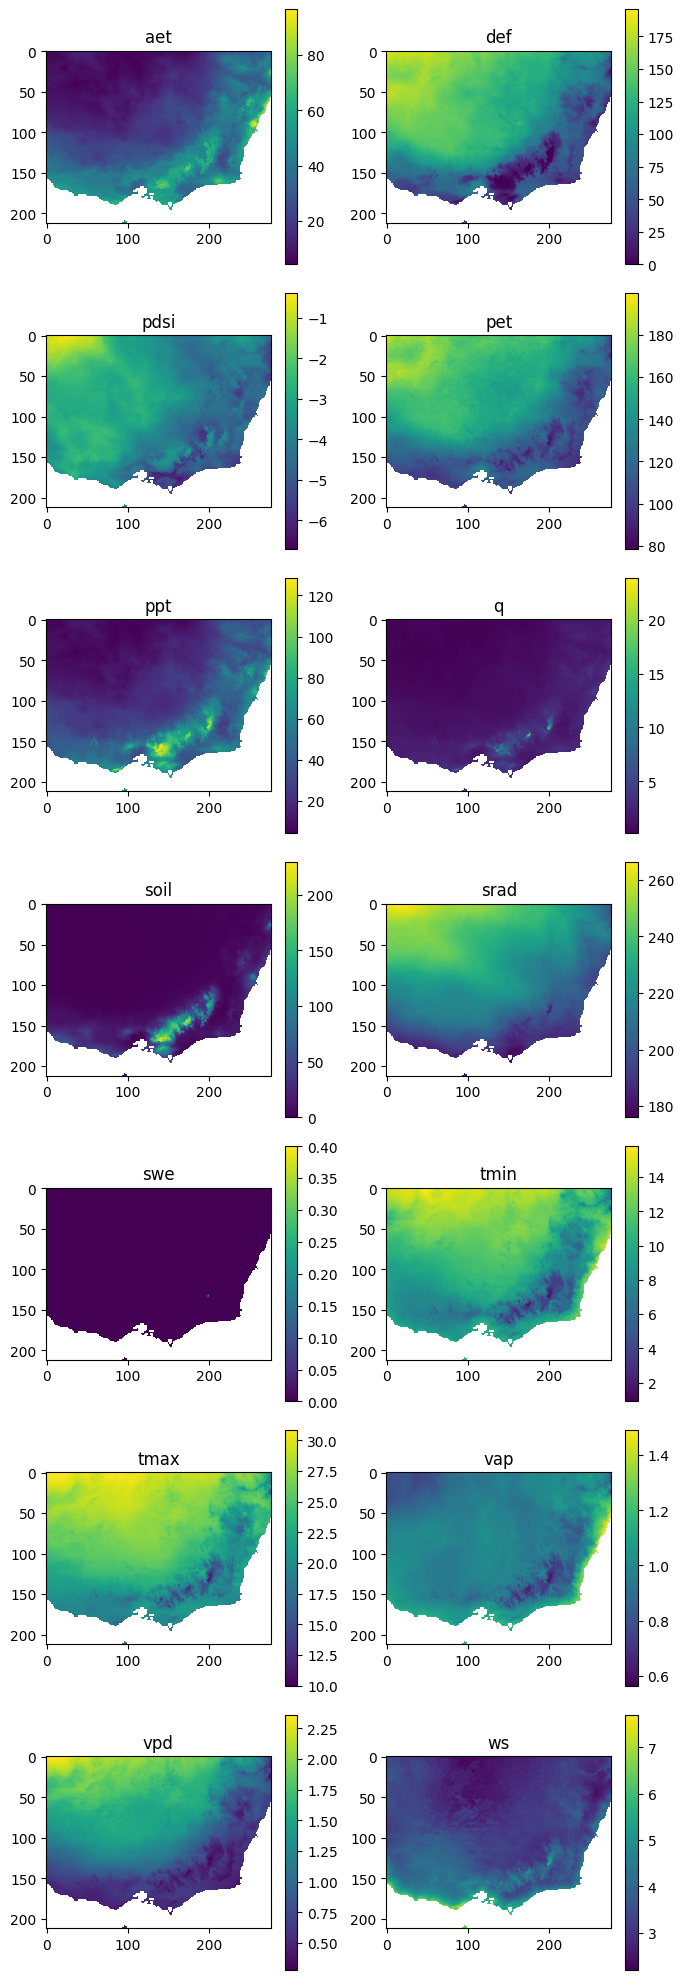

In [4]:
# Open the GeoTIFF file
tiff_path = "TerraClimate_output.tiff"

# Read the variables from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    variable1 = src1.read(1)  # variable [aet]
    variable2 = src1.read(2)  # variable [def]
    variable3 = src1.read(3)  # variable [pdsi]
    variable4 = src1.read(4)  # variable [pet]
    variable5 = src1.read(5)  # variable [ppt]
    variable6 = src1.read(6)  # variable [q]
    variable7 = src1.read(7)  # variable [soil]
    variable8 = src1.read(8)  # variable [srad]
    variable9 = src1.read(9)  # variable [swe]
    variable10 = src1.read(10)  # variable [tmin]
    variable11 = src1.read(11)  # variable [tmax]
    variable12 = src1.read(12)  # variable [vap]
    variable13 = src1.read(13)  # variable [vpd]
    variable14 = src1.read(14)  # variable [ws]

# Plot the variables in a 7x2 grid
fig, axes = plt.subplots(7, 2, figsize=(7, 20))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot the first parameter (aet)
im1 = axes[0].imshow(variable1, cmap='viridis')
axes[0].set_title('aet')
fig.colorbar(im1, ax=axes[0])

# Plot the second parameter (def)
im2 = axes[1].imshow(variable2, cmap='viridis')
axes[1].set_title('def')
fig.colorbar(im2, ax=axes[1])

# Plot the third parameter (pdsi)
im3 = axes[2].imshow(variable3, cmap='viridis')
axes[2].set_title('pdsi')
fig.colorbar(im3, ax=axes[2])

# Plot the fourth parameter (pet)
im4 = axes[3].imshow(variable4, cmap='viridis')
axes[3].set_title('pet')
fig.colorbar(im4, ax=axes[3])

# Plot the fifth parameter (ppt)
im5 = axes[4].imshow(variable5, cmap='viridis')
axes[4].set_title('ppt')
fig.colorbar(im5, ax=axes[4])

# Plot the sixth parameter (q)
im6 = axes[5].imshow(variable6, cmap='viridis')
axes[5].set_title('q')
fig.colorbar(im6, ax=axes[5])

# Plot the seventh parameter (soil)
im7 = axes[6].imshow(variable7, cmap='viridis')
axes[6].set_title('soil')
fig.colorbar(im7, ax=axes[6])

# Plot the eigth parameter (srad)
im8 = axes[7].imshow(variable8, cmap='viridis')
axes[7].set_title('srad')
fig.colorbar(im8, ax=axes[7])

# Plot the ninth parameter (swe)
im9 = axes[8].imshow(variable9, cmap='viridis')
axes[8].set_title('swe')
fig.colorbar(im9, ax=axes[8])

# Plot the tenth parameter (tmin)
im10 = axes[9].imshow(variable10, cmap='viridis')
axes[9].set_title('tmin')
fig.colorbar(im10, ax=axes[9])

# Plot the eleventh parameter (tmax)
im11 = axes[10].imshow(variable11, cmap='viridis')
axes[10].set_title('tmax')
fig.colorbar(im11, ax=axes[10])

# Plot the second parameter (vap)
im12 = axes[11].imshow(variable12, cmap='viridis')
axes[11].set_title('vap')
fig.colorbar(im12, ax=axes[11])

# Plot the second parameter (vpd)
im13 = axes[12].imshow(variable13, cmap='viridis')
axes[12].set_title('vpd')
fig.colorbar(im13, ax=axes[12])

# Plot the second parameter (ws)
im14 = axes[13].imshow(variable14, cmap='viridis')
axes[13].set_title('ws')
fig.colorbar(im14, ax=axes[13])

plt.tight_layout()
plt.show()

### Extract Climate variables from the TerraClimate sample GeoTIFF image.

We define a function map_satellite_data that reads satellite data from a GeoTIFF file and a CSV file containing latitude and longitude coordinates. We start by loading the CSV file into a DataFrame. Using rasterio, we open the GeoTIFF file and read 14 different environmental variables into numpy arrays. We then generate coordinate grids for latitude and longitude based on the raster bounds and resolution. Each variable is converted into an xarray.DataArray with appropriate coordinates. We initialize lists to store the extracted values for each variable. For each row in the DataFrame, we extract the nearest values from the DataArrays based on the latitude and longitude coordinates, handling any cases where coordinates are outside the raster bounds by assigning NaN values. Finally, we create a new DataFrame to store the extracted variable values and return it. This function allows us to map satellite data to specific geographic locations efficiently.

In [5]:
def map_satellite_data(tiff_path, csv_path):
    
    df = pd.read_csv(csv_path)

    with rasterio.open(tiff_path) as dataset:
        # Read raster variables into numpy arrays
        aet_data = dataset.read(1)  # variable 1 (e.g., aet)
        def_data = dataset.read(2)  # variable 2 (e.g., def)
        pdsi_data = dataset.read(3)  # variable 3 (e.g., pdsi)
        pet_data = dataset.read(4)  # variable 4 (e.g., pet)
        ppt_data = dataset.read(5)  # variable 5 (e.g., ppt)
        q_data = dataset.read(6)  # variable 6 (e.g., q)
        soil_data = dataset.read(7)  # variable 7 (e.g., soil)
        srad_data = dataset.read(8)  # variable 8 (e.g., srad)
        swe_data = dataset.read(9)  # variable 9 (e.g., swe)
        tmin_data = dataset.read(10)  # variable 10 (e.g., tmin)
        tmax_data = dataset.read(11)  # variable 11 (e.g., tmax)
        vap_data = dataset.read(12)  # variable 12 (e.g., vap)
        vpd_data = dataset.read(13)  # variable 13 (e.g., vpd)
        ws_data = dataset.read(14)  # variable 14 (e.g., ws)

        # Generate coordinate grids (lon/lat) from raster bounds and resolution
        lon = np.linspace(dataset.bounds.left, dataset.bounds.right, dataset.width)
        lat = np.linspace(dataset.bounds.top, dataset.bounds.bottom, dataset.height)

        # Create xarray DataArrays for each variable
        aet_da = xr.DataArray(
            aet_data, coords=[("lat", lat), ("lon", lon)], dims=["lat", "lon"]
        )
        def_da = xr.DataArray(
            def_data, coords=[("lat", lat), ("lon", lon)], dims=["lat", "lon"]
        )
        pdsi_da = xr.DataArray(
            pdsi_data, coords=[("lat", lat), ("lon", lon)], dims=["lat", "lon"]
        )
        pet_da = xr.DataArray(
            pet_data, coords=[("lat", lat), ("lon", lon)], dims=["lat", "lon"]
        )
        ppt_da = xr.DataArray(
            ppt_data, coords=[("lat", lat), ("lon", lon)], dims=["lat", "lon"]
        )
        q_da = xr.DataArray(
            q_data, coords=[("lat", lat), ("lon", lon)], dims=["lat", "lon"]
        )
        soil_da = xr.DataArray(
            soil_data, coords=[("lat", lat), ("lon", lon)], dims=["lat", "lon"]
        )
        srad_da = xr.DataArray(
            srad_data, coords=[("lat", lat), ("lon", lon)], dims=["lat", "lon"]
        )
        swe_da = xr.DataArray(
            swe_data, coords=[("lat", lat), ("lon", lon)], dims=["lat", "lon"]
        )
        tmin_da = xr.DataArray(
            tmin_data, coords=[("lat", lat), ("lon", lon)], dims=["lat", "lon"]
        )
        tmax_da = xr.DataArray(
            tmax_data, coords=[("lat", lat), ("lon", lon)], dims=["lat", "lon"]
        )
        vap_da = xr.DataArray(
            vap_data, coords=[("lat", lat), ("lon", lon)], dims=["lat", "lon"]
        )
        vpd_da = xr.DataArray(
            vpd_data, coords=[("lat", lat), ("lon", lon)], dims=["lat", "lon"]
        )
        ws_da = xr.DataArray(
            ws_data, coords=[("lat", lat), ("lon", lon)], dims=["lat", "lon"]
        )

    # Initialize lists to store extracted values
    aet_values = []
    def_values = []
    pdsi_values = []
    pet_values = []
    ppt_values = []
    q_values = []
    soil_values = []
    srad_values = []
    swe_values = []
    tmin_values = []
    tmax_values = []
    vap_values = []
    vpd_values = []
    ws_values = []

    # Extract values for each row in the DataFrame
    for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Extracting raster values"):
        target_lat, target_lon = row["Latitude"], row["Longitude"]

        try:
            # Extract the nearest values from the DataArrays
            aet_value = aet_da.sel(lat=target_lat, lon=target_lon, method="nearest").values
            def_value = def_da.sel(lat=target_lat, lon=target_lon, method="nearest").values
            pdsi_value = pdsi_da.sel(lat=target_lat, lon=target_lon, method="nearest").values
            pet_value = pet_da.sel(lat=target_lat, lon=target_lon, method="nearest").values
            ppt_value = ppt_da.sel(lat=target_lat, lon=target_lon, method="nearest").values
            q_value = q_da.sel(lat=target_lat, lon=target_lon, method="nearest").values
            soil_value = soil_da.sel(lat=target_lat, lon=target_lon, method="nearest").values
            srad_value = srad_da.sel(lat=target_lat, lon=target_lon, method="nearest").values
            swe_value = swe_da.sel(lat=target_lat, lon=target_lon, method="nearest").values
            tmin_value = tmin_da.sel(lat=target_lat, lon=target_lon, method="nearest").values
            tmax_value = tmax_da.sel(lat=target_lat, lon=target_lon, method="nearest").values
            vap_value = vap_da.sel(lat=target_lat, lon=target_lon, method="nearest").values
            vpd_value = vpd_da.sel(lat=target_lat, lon=target_lon, method="nearest").values
            ws_value = ws_da.sel(lat=target_lat, lon=target_lon, method="nearest").values
        except KeyError:
            # Handle cases where coordinates are outside raster bounds
            aet_value, def_value, pdsi_value, pet_value, ppt_value, q_value, soil_value, srad_value, swe_value, tmin_value, tmax_value, vap_value, vpd_value, ws_value = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

        aet_values.append(aet_value)
        def_values.append(def_value)
        pdsi_values.append(pdsi_value)
        pet_values.append(pet_value)
        ppt_values.append(ppt_value)
        q_values.append(q_value)
        soil_values.append(soil_value)
        srad_values.append(srad_value)
        swe_values.append(swe_value)
        tmin_values.append(tmin_value)
        tmax_values.append(tmax_value)
        vap_values.append(vap_value)
        vpd_values.append(vpd_value)
        ws_values.append(ws_value)
        
    # Create a DataFrame to store the variable values
    df1 = pd.DataFrame()
    df1["aet"] = aet_values
    df1["def"] = def_values
    df1["pdsi"] = pdsi_values
    df1["pet"] = pet_values
    df1["ppt"] = ppt_values
    df1["q"] = q_values
    df1["soil"] = soil_values
    df1["srad"] = srad_values
    df1["swe"] = swe_values
    df1["tmin"] = tmin_values
    df1["tmax"] = tmax_values
    df1["vap"] = vap_values
    df1["vpd"] = vpd_values
    df1["ws"] = ws_values

    return df1

In [6]:
# Mapping satellite data with training data.
final_data = map_satellite_data('TerraClimate_output.tiff', 'Training_Data.csv')

Extracting raster values:   1%|          | 71/6312 [00:00<00:46, 133.72it/s]

Extracting raster values: 100%|██████████| 6312/6312 [00:48<00:00, 130.88it/s]


## Joining Predictor Variables with the Response Variables

In [7]:
def combine_two_datasets(dataset1,dataset2):
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [8]:
# Combining ground data and final data into a single dataset.
final_data = combine_two_datasets(ground_df,final_data)

# Removing Duplicates

In [9]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ['aet', 'def', 'pdsi', 'pet', 'ppt', 'q', 'soil', 'srad', 'swe', 'tmin', 'tmax', 'vap', 'vpd', 'ws', 'Occurrence Status']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    final_data[col] = final_data[col].apply(lambda x: x.item() if isinstance(x, np.ndarray) and x.ndim == 0 else x)

# Now remove duplicates
final_data = final_data.drop_duplicates(subset=columns_to_check, keep='first')
final_data=final_data.reset_index(drop=True)
final_data.shape

(5285, 17)

# Operating on Dataset

In [10]:
final_data = final_data[['aet', 'def', 'pdsi', 'pet', 'ppt', 'q', 'soil', 'srad', 'swe', 'tmin', 'tmax', 'vap', 'vpd', 'ws', 'Occurrence Status']]

In [11]:
model_data = final_data.copy()

In [12]:
model_data

,aet,def,pdsi,pet,ppt,q,soil,srad,swe,tmin,tmax,vap,vpd,ws,Occurrence Status
0,53.500000,65.300003,-4.5,115.500000,49.7,2.5,16.700001,200.799149,0.0,12.599999,23.900000,1.233,0.81,3.6,1
1,24.700001,110.900002,-3.9,144.699997,25.9,1.3,2.500000,218.403992,0.0,10.900000,24.500000,0.942,1.33,3.1,1
2,51.299999,28.200001,-3.8,115.099998,69.9,3.5,68.800003,204.000031,0.0,8.099999,21.400000,0.942,0.78,3.2,0
3,41.000000,67.300003,-4.7,120.700005,45.0,2.3,11.300000,204.400146,0.0,8.000000,20.199999,0.951,0.70,4.4,1
4,58.900002,29.500000,-4.8,109.500000,71.1,3.6,43.000000,189.203964,0.0,9.900000,18.900000,1.096,0.50,5.6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5280,19.800001,122.300003,-3.1,147.199997,20.8,1.0,1.500000,229.799118,0.0,12.799999,27.299999,0.993,1.51,2.7,0
5281,31.300001,113.400002,-3.3,135.500000,31.1,1.6,4.900000,215.003052,0.0,8.900000,22.699999,0.975,1.00,3.9,1
5282,30.600000,94.900002,-2.7,130.199997,26.7,1.3,7.800000,212.802444,0.0,7.900000,22.100000,0.999,0.93,3.8,0
5283,40.700001,49.900002,-3.8,112.800003,48.1,2.4,25.000000,201.999481,0.0,7.100000,18.699999,0.941,0.59,4.5,1


# Training and Building ML Pipeline

Adding Libraries relevant to training and building machine learning models.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

The function best_binary_classifier is designed to evaluate and compare the performance of five different binary classification models (Logistic Regression, Support Vector Machine with RBF kernel, Decision Tree, Random Forest, and Naive Bayes) on a given dataset. It begins by extracting the target variable "Occurrence Status" and preparing the feature set, ensuring all column names are strings. The data is then split into training and testing sets with an 80-20 ratio, maintaining the original class distribution through stratification. Each model is trained on the training set and evaluated on the test set using accuracy as the performance metric. After comparing the accuracies of all models, the function identifies and reports the best-performing model, displaying its classification report and confusion matrix. Finally, it returns boolean flags indicating which model was selected as the best performer.

In [14]:
def best_binary_classifier(dataset):
    # Extract the target
    pred = dataset["Occurrence Status"]
    
    # Drop the target column from the features
    features = dataset.drop(columns=["Occurrence Status"])
    
    # Ensure all feature column names are strings
    features.columns = features.columns.astype(str)
    
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(features, pred, test_size=0.3, stratify=pred, random_state=42)

    # LogarithmicRegression
    bool_lr = False
    model_lr = LogisticRegression(max_iter=1000)
    model_lr.fit(x_train, y_train)
    predictions_lr = model_lr.predict(x_test)
    accuracy_lr = accuracy_score(y_test, predictions_lr)

    # SVM
    bool_svm = False
    model_svm = SVC(kernel="rbf", gamma=0.01, C=1.0)
    model_svm.fit(x_train, y_train)
    predictions_svm = model_svm.predict(x_test)
    accuracy_svm = accuracy_score(y_test, predictions_svm)

    # Decision Tree
    bool_dt = False
    model_dt = DecisionTreeClassifier()
    model_dt.fit(x_train, y_train)
    predictions_dt = model_dt.predict(x_test)
    accuracy_dt = accuracy_score(y_test, predictions_dt)

    # Random Forest
    bool_rf = False
    model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    model_rf.fit(x_train, y_train)
    predictions_rf = model_rf.predict(x_test)
    accuracy_rf = accuracy_score(y_test, predictions_rf)

    # Naive Bayes
    bool_nb = False
    model_nb = GaussianNB()
    model_nb.fit(x_train, y_train)
    predictions_nb = model_nb.predict(x_test)
    accuracy_nb = accuracy_score(y_test, predictions_nb)

    print("Accuracy of Logistic Regression Model: ", accuracy_lr)
    print("Accuracy of SVM: ", accuracy_svm)
    print("Accuracy of Decision Tree: ", accuracy_dt)
    print("Accuracy of Random Forest: ", accuracy_rf)
    print("Accuracy of Naive Bayes: ", accuracy_nb)
    print("\n")

    if (max(accuracy_lr, accuracy_svm, accuracy_dt, accuracy_rf, accuracy_nb) == accuracy_lr):
        print("Best Model: Logistic Regression")
        accuracy = accuracy_lr
        predictions = predictions_lr
        bool_lr = True
    elif (max(accuracy_lr, accuracy_svm, accuracy_dt, accuracy_rf, accuracy_nb) == accuracy_svm):
        print("Best Model: SVM")
        accuracy = accuracy_svm
        predictions = predictions_svm
        bool_svm = True
    elif (max(accuracy_lr, accuracy_svm, accuracy_dt, accuracy_rf, accuracy_nb) == accuracy_dt):
        print("Best Model: Decision Tree")
        accuracy = accuracy_dt
        predictions = predictions_dt
        bool_dt = True
    elif (max(accuracy_lr, accuracy_svm, accuracy_dt, accuracy_rf, accuracy_nb) == accuracy_rf):
        print("Best Model: Random Forest")
        accuracy = accuracy_rf
        predictions = predictions_rf
        bool_rf = True
    else:
        print("Best Model: Naive Bayes")
        accuracy = accuracy_nb
        predictions = predictions_nb
        bool_nb = True

    print("\n")

    print(classification_report(y_test, predictions))
    ConfusionMatrixDisplay(confusion_matrix(y_test,predictions)).plot()
    print("Accuracy of Best Model: ", accuracy)

    return bool_lr, bool_svm, bool_dt, bool_rf, bool_nb

Accuracy of Logistic Regression Model:  0.6595208070617906
Accuracy of SVM:  0.7175283732660782
Accuracy of Decision Tree:  0.6229508196721312
Accuracy of Random Forest:  0.7137452711223203
Accuracy of Naive Bayes:  0.6437578814627994


Best Model: SVM


              precision    recall  f1-score   support

           0       0.71      0.66      0.69       741
           1       0.72      0.77      0.74       845

    accuracy                           0.72      1586
   macro avg       0.72      0.71      0.71      1586
weighted avg       0.72      0.72      0.72      1586

Accuracy of Best Model:  0.7175283732660782


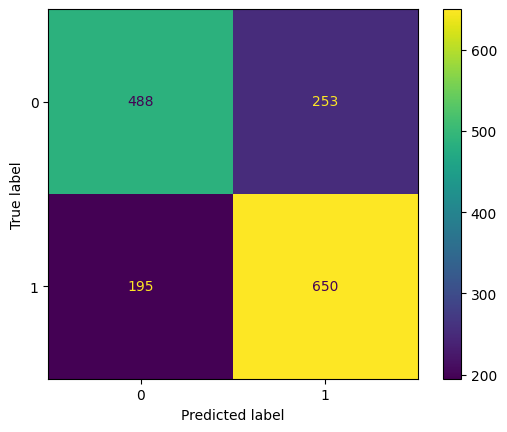

In [15]:
bool_lr, bool_svm, bool_dt, bool_rf, bool_nb = best_binary_classifier(model_data)

The function apply_best_model is designed to apply a previously selected optimal binary classification model to new data for prediction. It accepts boolean flags indicating which model (Logistic Regression, SVM, Decision Tree, Random Forest, or Naive Bayes) was determined to be the best performer, along with training and test datasets. The function extracts the target variable "Occurrence Status" from both datasets, prepares the feature sets by removing the target column, and ensures all feature column names are strings. Based on the boolean flags, it trains the specified model on the training data, makes predictions on the test data, and generates a submission file containing the predicted "Occurrence Status" along with corresponding latitude and longitude values from the test dataset.

In [16]:
def apply_best_model(bool_lr, bool_svm, bool_dt, bool_rf, bool_nb, dataset1, dataset2):
    # Extract the target
    y_train = dataset1["Occurrence Status"]
    
    # Drop the target column from the features
    x_train = dataset1.drop(columns=["Occurrence Status"])
    x_test = dataset2
    
    # Ensure all feature column names are strings
    x_train.columns = x_train.columns.astype(str)
    
    # LogarithmicRegression
    if (bool_lr):
        model_lr = LogisticRegression(max_iter=1000)
        model_lr.fit(x_train, y_train)
        predictions = model_lr.predict(x_test)

    # SVM
    if (bool_svm):
        model_svm = SVC(kernel="rbf", gamma=0.01, C=1.0)
        model_svm.fit(x_train, y_train)
        predictions = model_svm.predict(x_test)
    

    # Decision Tree
    if (bool_dt):
        model_dt = DecisionTreeClassifier()
        model_dt.fit(x_train, y_train)
        predictions = model_dt.predict(x_test)    

    # Random Forest
    if (bool_rf):
        model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
        model_rf.fit(x_train, y_train)
        predictions= model_rf.predict(x_test)    

    # Naive Bayes
    if (bool_nb):
        model_nb = GaussianNB()
        model_nb.fit(x_train, y_train)
        predictions = model_nb.predict(x_test)

    final_prediction_series = pd.Series(predictions)
    return final_prediction_series
    

# Model Validation

In [17]:
test_file = pd.read_csv('Validation_Template.csv')
test_file.head()

,Latitude,Longitude
0,-33.121788,150.320746
1,-36.592011,148.172262
2,-35.455100,146.693465
3,-33.076261,149.547177
4,-35.529729,146.627272


In [18]:
test_file.shape

(2000, 2)

In [19]:
final_val_data = map_satellite_data('TerraClimate_output.tiff', 'Validation_Template.csv')

Extracting raster values:   2%|▏         | 30/2000 [00:00<00:13, 147.05it/s]

Extracting raster values: 100%|██████████| 2000/2000 [00:15<00:00, 131.47it/s]


In [20]:
final_prediction_series = apply_best_model(bool_lr, bool_svm, bool_dt, bool_rf, bool_nb, model_data, final_val_data)
submission_df = pd.DataFrame({'Latitude':test_file['Latitude'].values, 'Longitude':test_file['Longitude'].values,  'Occurrence Status':final_prediction_series.values})
submission_df.to_csv("Predicted_Data.csv",index = False)